In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [20]:
player_transfers = pd.read_json('players_transfers.json')
player_transfers = player_transfers.loc[:, ['Player_id','Season','Fee','destination_id']] 
player_transfers = player_transfers.loc[~player_transfers['Fee'].str.contains('Loan')]
player_transfers = player_transfers.loc[player_transfers['Fee'].str.contains('[kmb]')]

def convert_value_to_euros(value):
    value = value.replace('€', '')
    factor = 1 
    if value.endswith('m'):
        factor = 1000000
        value = value.replace('m', '')
    elif value.endswith('k'):
        factor = 1000
        value = value.replace('k', '')
    elif value.endswith('b'):
        factor = 1000000000
        value = value.replace('b', '')    
    else:
        factor = 0
    return float(value)*factor
player_transfers['Fee']=player_transfers['Fee'].apply(convert_value_to_euros)
# print(player_transfers)

In [21]:
filtered_seasons = player_transfers[player_transfers['Season'].isin(['21/22', '17/18','18/19','19/20','20/21'])]
grouped_transfers = filtered_seasons.groupby(['destination_id', 'Season'])['Fee'].sum().reset_index()
# print(grouped_transfers)
# grouped_transfers.destination_id.value_counts()

In [22]:
all_teams = pd.read_json('league_data.json')
all_teams = all_teams[all_teams['Season'].isin(['2017-2018', '2018-2019','2019-2020','2020-2021','2021-2022'])]
teams_list = all_teams.club_id.to_list()
teams_list = np.unique(teams_list)

In [23]:
final_ans = grouped_transfers.groupby(['Season'])['Fee'].sum().reset_index()

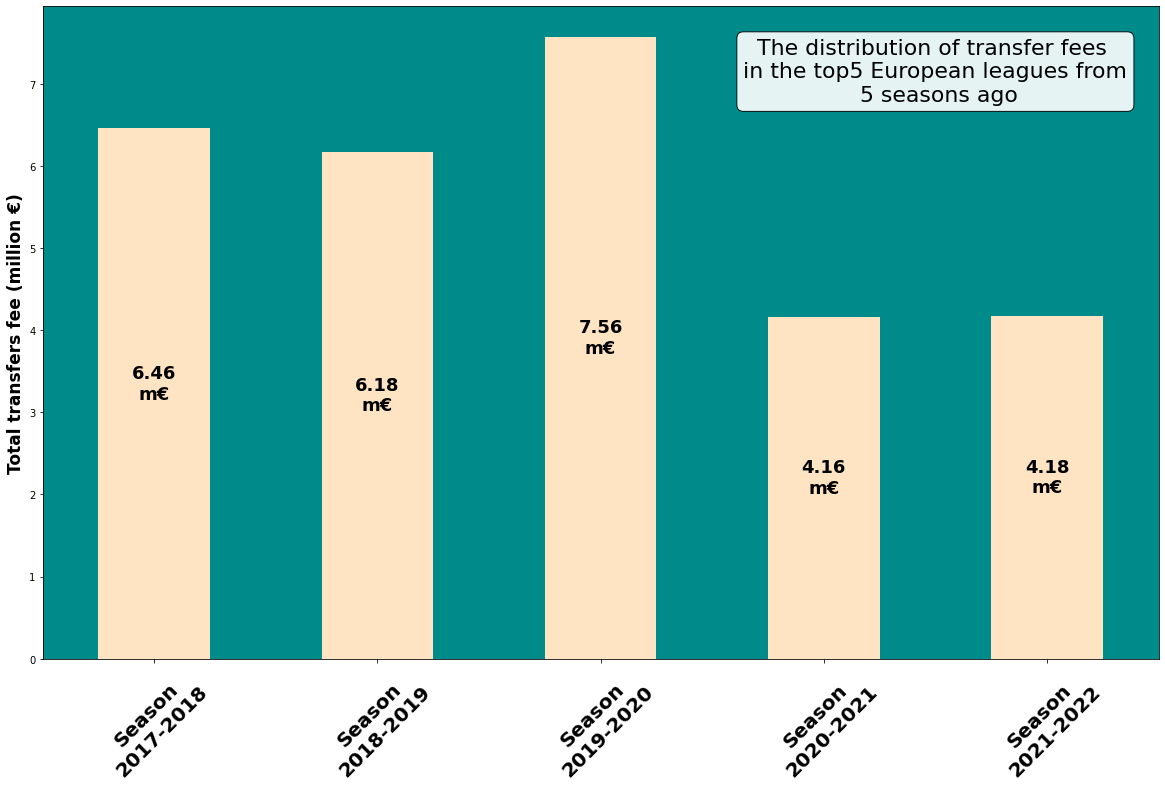

In [24]:
V = final_ans['Fee']/1000000000

plt.figure(figsize=(20, 12))  
ax = V.plot(kind='bar',color = 'bisque')
plt.ylabel('Total transfers fee (million €)' , fontsize=17 ,fontweight = 'bold')
ax.set_xticklabels(['Season\n2017-2018', 'Season\n2018-2019','Season\n2019-2020','Season\n2020-2021','Season\n2021-2022'] ,fontsize=20, rotation = 45 , fontweight = 'bold')
# plt.title('The distribution of transfer fees in the top \n5 European leagues from 5 seasons ago'  , fontsize=17)
ax.set_facecolor('darkcyan')


for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2))+'\nm€', 
                (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=18 ,fontweight = 'bold')
    

# Add the text box with the title
title_box = {
    'boxstyle': 'round',
    'facecolor': 'white',
    'edgecolor': 'black',
    'alpha': 0.9
}

ax.text(0.8, 0.9, 'The distribution of transfer fees \nin the top5 European leagues from\n 5 seasons ago', 
        fontsize=22, ha='center', va='center', transform=ax.transAxes, bbox=title_box)


plt.show()

In [25]:
top10_destinations = grouped_transfers.groupby(['destination_id'])['Fee'].sum().sort_values(ascending=False).head(10).index.tolist()
top10_destinations

[131, 506, 631, 281, 583, 985, 13, 11, 418, 5]

In [26]:
R = all_teams.loc[all_teams['club_id'].isin(top10_destinations)]
R = R.rename(columns={"club_id":'destination_id'})

In [27]:

temp = grouped_transfers.groupby(['destination_id','Season'])['Fee'].sum()
temp = temp.loc[top10_destinations].reset_index()
temp = temp[temp['destination_id'].isin(top10_destinations)]
map_season = lambda season: f'20{season[:2]}-20{season[-2:]}'
temp['Season'] = temp['Season'].apply(map_season)
merged_df = pd.merge(temp, R, on=['Season','destination_id'] , how='left')
merged_df = merged_df.loc[:,['Season','Fee','Club']]

In [28]:
new_row = {'Season': '2020-2021', 'Fee':0.0 ,'Club': 'Real Madrid'}
merged_df.loc[len(merged_df)] = new_row

In [29]:
merged_df = merged_df.sort_values(['Club','Season'])
merged_df['Fee']=merged_df['Fee']/1000000

In [30]:
team_data = {}
for index, row in merged_df.iterrows():
    team = row['Club']
    year = row['Season']
    fee = row['Fee']
    if team not in team_data:
        team_data[team] = []
    team_data[team].append(fee)


In [31]:
seasons = ['2017/18','2018/19','2019/20','2020/21','2021/22']

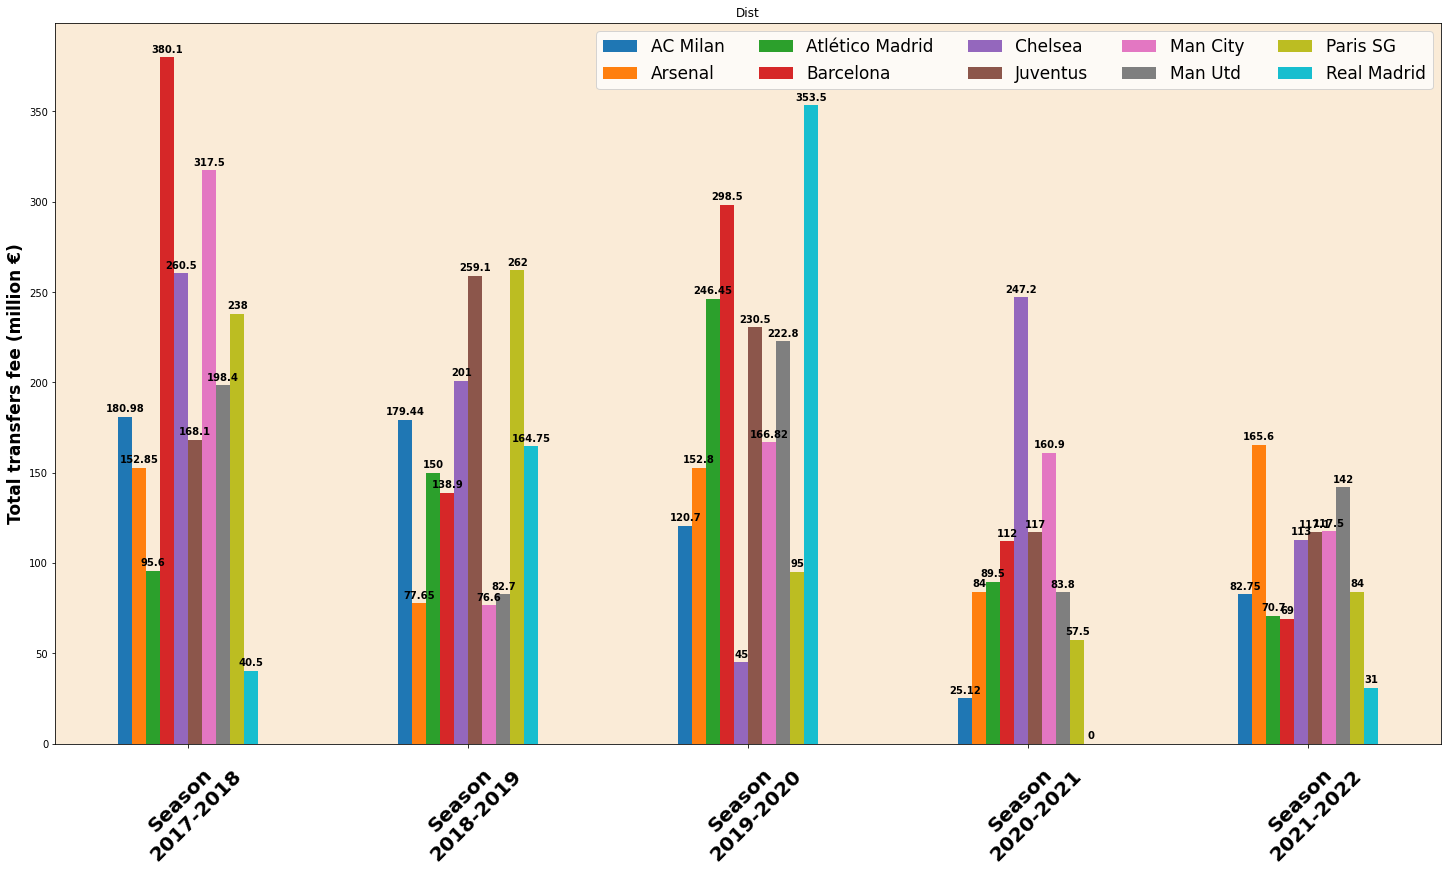

In [32]:

x = np.arange(len(seasons))  # the label locations
width = 0.05  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(20, 12))

for attribute, measurement in team_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset-.175, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3,fontweight = 'bold')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total transfers fee (million €)' , fontsize=17 ,fontweight = 'bold')
ax.set_title('Dist')
ax.set_xticks(x + width,['Season\n2017-2018', 'Season\n2018-2019','Season\n2019-2020','Season\n2020-2021','Season\n2021-2022'] ,fontsize=20, rotation = 45 , fontweight = 'bold')
ax.legend(loc='upper right', ncols=5 , fontsize=17)
ax.set_facecolor('antiquewhite')
# ax.set_ylim(0, 250)